# PART 3
---

Objective: Benchmark your model against the SOA with the full dataset now available.

In [1]:
%%capture
!pip install -U datasets transformers evaluate transformers-interpret

In [2]:
# from utils import Metrics
from datasets import load_dataset, DatasetDict, load_from_disk
from datasets import Dataset
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification,
                          TrainingArguments, Trainer,
                          EarlyStoppingCallback)
import evaluate, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
import torch, random, os
import json
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set_style("darkgrid")
#set palette to Spectral
sns.set_palette("Spectral")
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [3]:
#mount collab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
OUTPUT_DIR = "/content/drive/MyDrive/NLP_trial_final_project/abstracts"

In [5]:
if Path(f"{OUTPUT_DIR}/dataset_patents_abstracts").exists():
  dataset = load_from_disk(f"{OUTPUT_DIR}/dataset_patents_abstracts")
else:
  dataset = load_dataset("ccdv/patent-classification", "abstract")
  dataset.save_to_disk(f"{OUTPUT_DIR}/dataset_patents_abstracts")

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
})

## Utils

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

class Metrics:
    def __init__(self):
        self.results = {}

    def run(self, y_true, y_pred, method_name, average='macro'):
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average=average)
        recall = recall_score(y_true, y_pred, average=average)
        f1 = f1_score(y_true, y_pred, average=average)

        # Store results
        self.results[method_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    def plot(self, custom_palette=None, save_plot_path=None):
        # Default color palette
        methods = list(self.results.keys())
        if custom_palette is None:
            custom_palette = sns.color_palette("Spectral", n_colors=len(methods))

        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        metric_names = ['Accuracy', 'Precision', 'Recall', 'F1']

        for i, metric in enumerate(metric_names):
            ax = axs[i // 2, i % 2]
            values = [self.results[m][metric.lower()] * 100 for m in methods]

            # Plot bars
            ax.bar(methods, values, color=custom_palette)
            ax.set_title(metric)
            ax.set_ylim(0, 100)

            # Annotate bars
            for j, v in enumerate(values):
                ax.text(j, v + 1, f"{v:.2f}", ha='center', va='bottom')

            # Rotate x-axis labels
            ax.set_xticks(range(len(methods)))
            ax.set_xticklabels(methods, rotation=45)

            # Style spines
            ax.spines['bottom'].set_color('black')
            ax.spines['left'].set_color('black')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            # Style ticks
            ax.tick_params(axis='y', colors='black', direction='in', length=5, width=1)
            ax.tick_params(axis='x', colors='black', direction='in', length=5, width=1)

        plt.tight_layout()
        if save_plot_path:
            plt.savefig(save_plot_path, bbox_inches='tight')
        plt.show()


# 3.a. Full Dataset Training (0.25 points):
Incrementally train your model with varying percentages of the full dataset (1%, 10%, 25%, 50%, 75%, and 100%). Record the results.

In [7]:
n_classes = len(set(dataset['train']['label']))
n_classes

9

In [8]:
# model_ckpt   = "distilbert/distilbert-base-uncased"
model_ckpt   = "FacebookAI/roberta-base"
num_labels   = n_classes
max_length   = 256
batch_size   = 64
seed         = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(seed)

In [9]:
def keep_balanced_proportional(dataset, proportion=0.1, seed=42):
    df = dataset.to_pandas()
    rng = np.random.default_rng(seed)

    total_samples = round(len(df) * proportion)
    class_counts = df['labels'].value_counts()
    num_classes = len(class_counts)

    # Compute max balanced per class
    max_per_class = total_samples // num_classes

    # If the smallest class can't support that, balance isn't feasible
    if max_per_class <= class_counts.min():
        # Balanced sampling
        balanced_df = (
            df.groupby('labels')
            .apply(lambda x: x.sample(n=max_per_class, random_state=seed))
            .reset_index(drop=True)
        )
        return DatasetDict({"train": Dataset.from_pandas(balanced_df)})
    else:
        # Imbalanced fallback: sample randomly while keeping total size
        fallback_df = df.sample(n=total_samples, random_state=seed).reset_index(drop=True)
        return DatasetDict({"train": Dataset.from_pandas(fallback_df)})

In [10]:
metric_accuracy  = evaluate.load("accuracy")
metric_precision = evaluate.load("precision")
metric_recall    = evaluate.load("recall")

In [11]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc  = metric_accuracy.compute(predictions=preds, references=labels)
    prec = metric_precision.compute(predictions=preds, references=labels, average="weighted", zero_division=0)
    rec  = metric_recall.compute(predictions=preds, references=labels, average="weighted", zero_division=0)

    # merge into a single dict that Trainer can log
    return {
        "accuracy":  acc["accuracy"],
        "precision": prec["precision"],
        "recall":    rec["recall"],
    }

In [14]:
def create_args_training(n_epochs, output_dir):
  args = TrainingArguments(
      output_dir          = output_dir,
      eval_strategy       = "epoch",
      save_strategy       = "epoch",
      logging_strategy    = "epoch",
      logging_steps       = 50,
      learning_rate       = 2e-5,
      per_device_train_batch_size = batch_size,
      per_device_eval_batch_size  = batch_size,
      num_train_epochs    = n_epochs,
      weight_decay        = 0.01,
      load_best_model_at_end = True,
      metric_for_best_model = "eval_loss",
      save_total_limit    = 2,
      seed                = seed,
      report_to           = "none",  # Disable wandb
      fp16                = torch.cuda.is_available(), # Enable mixed precision training
      gradient_accumulation_steps = 2,
      dataloader_pin_memory=torch.cuda.is_available(),
  )
  return args

In [14]:
if Path(f"{OUTPUT_DIR}/dataset_patents_abstracts_tokenized_{model_ckpt}").exists():
  dataset = load_from_disk(f"{OUTPUT_DIR}/dataset_patents_abstracts_tokenized_{model_ckpt}")
  dataset.set_format("torch")
else:
  tok = AutoTokenizer.from_pretrained(model_ckpt)
  def tokenize(batch):
      return tok(batch["text"], padding="max_length", truncation=True, max_length=max_length)

  dataset = dataset.map(tokenize, batched=True, remove_columns=["text"])
  dataset = dataset.rename_column("label", "labels")
  dataset.set_format("torch")
  dataset.save_to_disk(f"{OUTPUT_DIR}/dataset_patents_abstracts_tokenized_{model_ckpt}")

In [15]:
def train_and_predict(dataset, model, args, results_object, prop):
    sample_training = dataset["train"].shuffle(seed=42)
    sample_training = keep_balanced_proportional(sample_training, proportion=prop, seed=42)
    print(sample_training)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_ckpt,
        num_labels = num_labels,
        problem_type = "single_label_classification"
    )

    trainer = Trainer(
        model           = model,
        args            = args,
        train_dataset   = sample_training['train'],
        eval_dataset    = dataset["validation"].shuffle(seed=seed),
        compute_metrics = compute_metrics,
        callbacks       = [EarlyStoppingCallback(early_stopping_patience=3)]
    )

    train_output = trainer.train()
    predictions = trainer.predict(dataset["test"])

    y_pred = np.argmax(predictions.predictions, axis=1)
    y_true = predictions.label_ids
    results_object.run(y_true, y_pred, f'D-BERT ({prop})', average='weighted')
    return results_object, y_pred.tolist(), y_true.tolist()

In [16]:
results = Metrics()
predictions = {}
for train_proportion in [0.01, 0.1, 0.25, 0.5, 0.75, 1]:
    print(f"Training with {train_proportion * 100}% of the training data")
    args = create_args_training(n_epochs=20,
                                output_dir= f"{OUTPUT_DIR}/{model_ckpt}/results_{train_proportion*100}"
                                )
    results, y_pred, y_true = train_and_predict(dataset, model_ckpt, args, results, train_proportion)
    predictions[train_proportion] = {
        "y_pred": y_pred,
        "y_true": y_true
    }
    with open( f"{OUTPUT_DIR}/{model_ckpt}/predictions.json", "w") as f:
        json.dump(predictions, f)

Training with 1.0% of the training data
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 243
    })
})


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,2.206300,2.248288,0.069400,0.004816,0.069400
2,2.209300,2.240135,0.069400,0.004816,0.069400
3,2.200400,2.232542,0.069400,0.004816,0.069400
4,2.192500,2.223385,0.069200,0.004822,0.069200
5,2.189000,2.208790,0.064800,0.051615,0.064800
6,2.165100,2.193101,0.141200,0.214876,0.141200
7,2.160200,2.170059,0.217000,0.416262,0.217000
8,2.117300,2.136817,0.243600,0.347767,0.243600
9,2.066600,2.087464,0.266000,0.370000,0.266000
10,2.004200,2.036261,0.268000,0.367518,0.268000


Training with 10.0% of the training data
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 2500
    })
})


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,1.992700,1.679603,0.427000,0.378113,0.427000
2,1.531200,1.422993,0.500000,0.512372,0.500000
3,1.303300,1.256591,0.567800,0.517719,0.567800
4,1.141300,1.207235,0.583000,0.549857,0.583000
5,1.020100,1.190204,0.602200,0.569869,0.602200
6,0.916100,1.174880,0.611000,0.574764,0.611000
7,0.795900,1.192023,0.611000,0.582446,0.611000
8,0.751900,1.218098,0.611200,0.572659,0.611200
9,0.642400,1.225809,0.614200,0.580482,0.614200


Training with 25.0% of the training data
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 6250
    })
})


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,1.695500,1.328649,0.530200,0.491656,0.530200
2,1.229000,1.158492,0.603200,0.577012,0.603200
3,1.051100,1.115240,0.632600,0.588610,0.632600
4,0.925900,1.085082,0.642200,0.602700,0.642200
5,0.808300,1.112141,0.635600,0.598959,0.635600
6,0.721000,1.119664,0.641400,0.613419,0.641400
7,0.631800,1.156864,0.632400,0.612883,0.632400


Training with 50.0% of the training data
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 12500
    })
})


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,1.488300,1.122657,0.621000,0.594375,0.621000
2,1.067800,1.032956,0.650800,0.628121,0.650800
3,0.925600,1.035700,0.653800,0.621964,0.653800
4,0.819300,1.031308,0.660800,0.629427,0.660800
5,0.725400,1.100658,0.645200,0.623268,0.645200
6,0.635000,1.099543,0.653800,0.636445,0.653800
7,0.559300,1.149853,0.653000,0.630687,0.653000


Training with 75.0% of the training data
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 18750
    })
})


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,1.372700,1.052384,0.640800,0.594054,0.640800
2,1.001800,1.023952,0.641800,0.619292,0.641800
3,0.881400,0.982045,0.664800,0.634227,0.664800
4,0.783300,0.999609,0.663200,0.645168,0.663200
5,0.696300,1.012704,0.667400,0.640747,0.667400
6,0.614400,1.058642,0.673000,0.643830,0.673000


Training with 100% of the training data
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
})


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,1.273800,1.033373,0.652000,0.623480,0.652000
2,0.966500,0.968537,0.671800,0.639577,0.671800
3,0.856300,0.953039,0.679400,0.648488,0.679400
4,0.759900,0.969254,0.669200,0.645561,0.669200
5,0.676300,0.984817,0.675200,0.650285,0.675200
6,0.595800,1.017086,0.677200,0.652827,0.677200


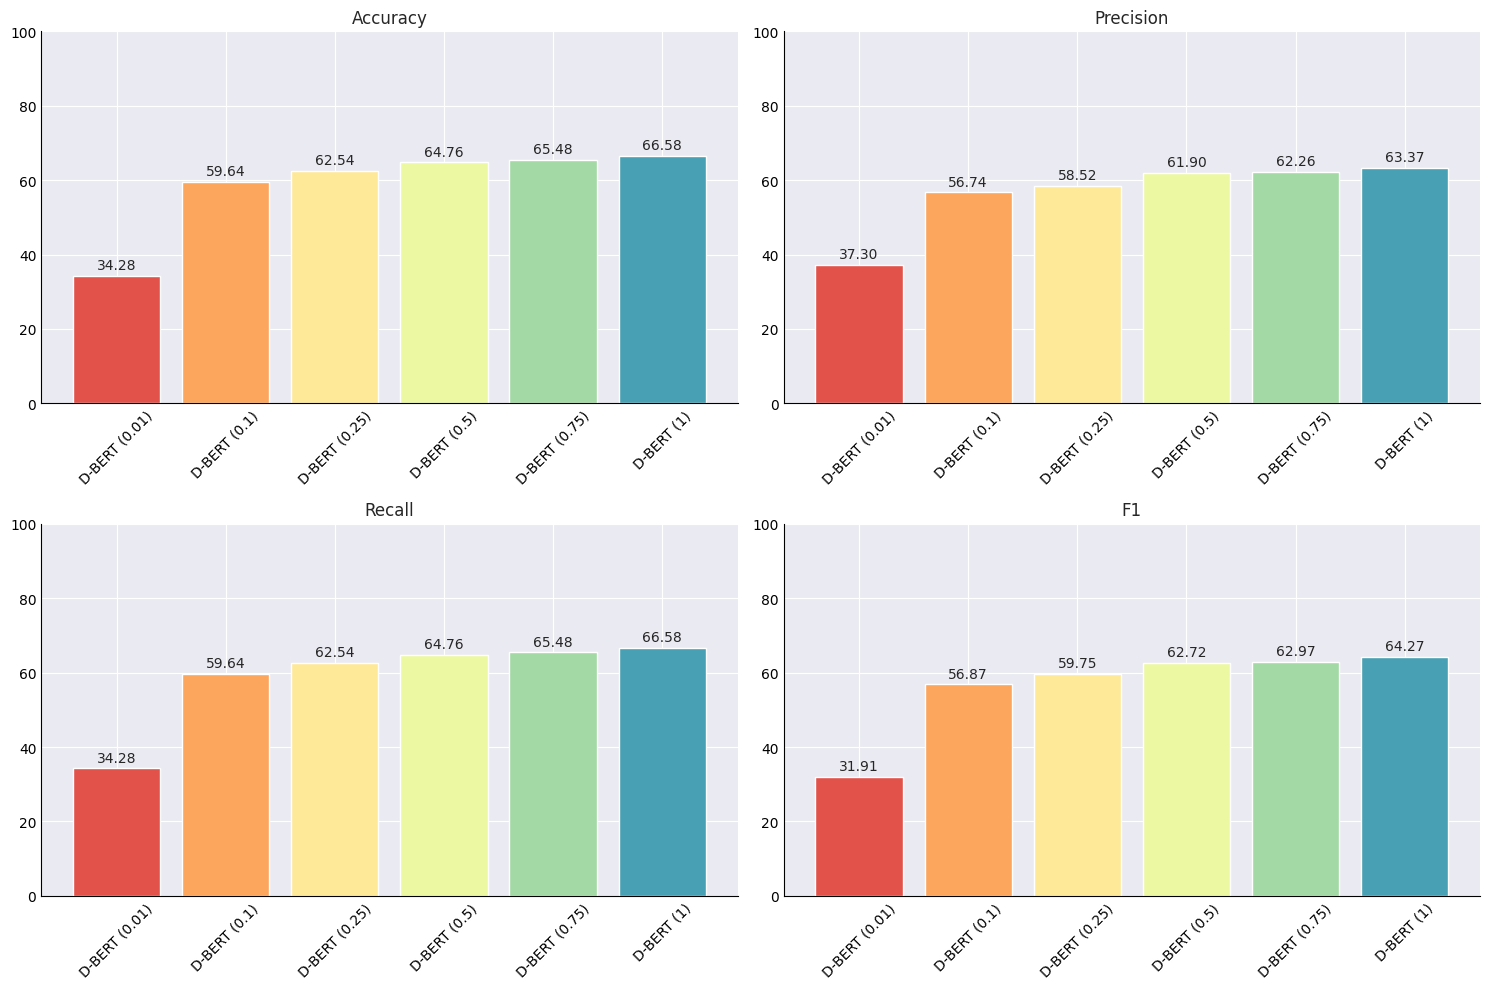

In [18]:
results.plot(save_plot_path=f"{OUTPUT_DIR}/{model_ckpt}/results_test.png")

# Inside RoBERTA - Understanding predictions

## Utils 2

In [16]:
from transformers_interpret import SequenceClassificationExplainer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generalized class names - update this for your dataset
CLASS_NAMES = {
    0: "Human Needs", 1: "Operations & Transport", 2: "Chemistry & Metallurgy",
    3: "Textiles & Paper", 4: "Construction", 5: "Mechanical & Thermal Engineering",
    6: "Physics", 7: "Electricity", 8: "Cross-Tech Tagging"
}

def bert_interpretability_analysis(model, tokenizer, confused_examples, target_labels=None):
    """
    Generalized BERT interpretation for any label confusion

    Args:
        model: Trained model
        tokenizer: Model tokenizer
        confused_examples: List of (text, true_label, pred_label) tuples
        target_labels: Optional tuple of (true_label, pred_label) to filter for
    """

    # Initialize the explainer
    explainer = SequenceClassificationExplainer(model=model, tokenizer=tokenizer)
    analysis_results = []

    # Filter examples if target_labels specified
    if target_labels:
        true_target, pred_target = target_labels
        confused_examples = [(text, true, pred) for text, true, pred in confused_examples
                           if true == true_target and pred == pred_target]
        print(f"🎯 Focusing on: {CLASS_NAMES[true_target]} → {CLASS_NAMES[pred_target]}")

    for i, (text, true_label, pred_label) in enumerate(confused_examples[:5]):
        print(f"\n{'='*50}")
        print(f"CONFUSED EXAMPLE {i+1}")
        print(f"True: {CLASS_NAMES[true_label]} | Predicted: {CLASS_NAMES[pred_label]}")

        # Truncate text to fit model's max length
        tokens = tokenizer.encode(text, add_special_tokens=False)
        if len(tokens) > 500:
            tokens = tokens[:500]
            text = tokenizer.decode(tokens, skip_special_tokens=True)
            print(f"⚠️  Text truncated to {len(tokens)} tokens")

        print(f"Text snippet: {text[:150]}...")

        try:
            # Get word attributions
            word_attributions = explainer(text)

            # Create visualization
            try:
                explainer.visualize(f"confusion_{CLASS_NAMES[true_label].replace(' ', '_')}_to_{CLASS_NAMES[pred_label].replace(' ', '_')}_{i+1}")
                print(f"📊 Visualization saved as HTML file")
            except Exception as viz_error:
                print(f"⚠️  HTML visualization failed: {viz_error}")

                # Fallback matplotlib plot
                words = [word for word, score in word_attributions[:15]]
                scores = [score for word, score in word_attributions[:15]]

                plt.figure(figsize=(12, 6))
                colors = ['red' if s < 0 else 'green' for s in scores]
                plt.barh(range(len(words)), scores, color=colors, alpha=0.7)
                plt.yticks(range(len(words)), words)
                plt.xlabel('Attribution Score')
                plt.title(f'Example {i+1}: {CLASS_NAMES[true_label]} → {CLASS_NAMES[pred_label]}')
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()

            # Store attribution data
            attribution_data = []
            for word, score in word_attributions:
                attribution_data.append({
                    'word': word,
                    'attribution': score,
                    'abs_attribution': abs(score)
                })

            attribution_df = pd.DataFrame(attribution_data)
            attribution_df = attribution_df.sort_values('abs_attribution', ascending=False)

            print(f"\n🔍 Top 10 most influential words:")
            for _, row in attribution_df.head(10).iterrows():
                direction = "→" if row['attribution'] > 0 else "←"
                print(f"  {direction} '{row['word']}': {row['attribution']:.4f}")

            analysis_results.append({
                'example_id': i,
                'true_label': true_label,
                'pred_label': pred_label,
                'text': text,
                'attributions': attribution_df
            })

        except Exception as e:
            print(f"❌ Error processing example {i}: {e}")
            continue

    return analysis_results

def analyze_confusion_patterns_general(analysis_results, label_pair=None):
    """
    Generalized confusion pattern analysis for any label pair

    Args:
        analysis_results: Results from interpretability analysis
        label_pair: Optional (true_label, pred_label) tuple to focus on
    """

    print(f"\n{'='*60}")
    print("CONFUSION PATTERN ANALYSIS")
    print(f"{'='*60}")

    if label_pair:
        true_label, pred_label = label_pair
        # Filter for specific confusion direction
        filtered_results = [r for r in analysis_results
                          if r['true_label'] == true_label and r['pred_label'] == pred_label]

        if filtered_results:
            print(f"\n🎯 {CLASS_NAMES[true_label]} → {CLASS_NAMES[pred_label]} ({len(filtered_results)} examples):")

            # Find common influential words
            common_words = defaultdict(list)
            for result in filtered_results:
                top_words = result['attributions'].head(15)
                for _, row in top_words.iterrows():
                    if row['attribution'] > 0:  # Words pushing toward predicted class
                        common_words[row['word']].append(row['attribution'])

            # Show most misleading words
            avg_attribution = {word: np.mean(scores) for word, scores in common_words.items()
                              if len(scores) >= 1}

            if avg_attribution:
                sorted_words = sorted(avg_attribution.items(), key=lambda x: x[1], reverse=True)
                print(f"Words misleading model toward '{CLASS_NAMES[pred_label]}' prediction:")
                for word, avg_score in sorted_words[:10]:
                    freq = len(common_words[word])
                    print(f"  '{word}': {avg_score:.4f} (appears {freq}x)")
    else:
        # Analyze all confusion patterns
        confusion_groups = defaultdict(list)
        for result in analysis_results:
            key = (result['true_label'], result['pred_label'])
            confusion_groups[key].append(result)

        for (true_label, pred_label), results in confusion_groups.items():
            print(f"\n🎯 {CLASS_NAMES[true_label]} → {CLASS_NAMES[pred_label]} ({len(results)} examples):")

            common_words = defaultdict(list)
            for result in results:
                top_words = result['attributions'].head(10)
                for _, row in top_words.iterrows():
                    if row['attribution'] > 0:
                        common_words[row['word']].append(row['attribution'])

            avg_attribution = {word: np.mean(scores) for word, scores in common_words.items()
                              if len(scores) >= 1}

            if avg_attribution:
                sorted_words = sorted(avg_attribution.items(), key=lambda x: x[1], reverse=True)
                print(f"  Top misleading words:")
                for word, avg_score in sorted_words[:5]:
                    freq = len(common_words[word])
                    print(f"    • '{word}': {avg_score:.4f} ({freq}x)")

def find_most_confused_pairs(y_true, y_pred, top_n=5):
    """
    Automatically find the most confused label pairs

    Args:
        y_true: True labels
        y_pred: Predicted labels
        top_n: Number of top confused pairs to return

    Returns:
        List of (true_label, pred_label, count) tuples
    """

    # Get confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Find off-diagonal elements (misclassifications)
    confused_pairs = []
    for i in range(len(cm)):
        for j in range(len(cm)):
            if i != j and cm[i][j] > 0:  # Misclassification
                confused_pairs.append((i, j, cm[i][j]))

    # Sort by confusion count
    confused_pairs.sort(key=lambda x: x[2], reverse=True)

    print(f"🔍 Top {top_n} most confused label pairs:")
    for i, (true_label, pred_label, count) in enumerate(confused_pairs[:top_n]):
        print(f"  {i+1}. {CLASS_NAMES[true_label]} → {CLASS_NAMES[pred_label]}: {count} examples")

    return confused_pairs[:top_n]

def investigate_label_confusion_comprehensive(trainer, original_dataset, tokenizer,
                                            target_labels=None, auto_find_top=True):
    """
    Comprehensive label confusion analysis

    Args:
        trainer: Trained model trainer
        original_dataset: Dataset with text column
        tokenizer: Model tokenizer
        target_labels: Optional (true_label, pred_label) tuple to focus on
        auto_find_top: Whether to automatically find most confused pairs first
    """

    print("🔍 Starting Comprehensive Label Confusion Analysis...")
    print("=" * 60)

    # Get predictions
    predictions = trainer.predict(original_dataset["test"])
    y_pred = np.argmax(predictions.predictions, axis=1)
    y_true = predictions.label_ids
    test_texts = original_dataset["test"]["text"]

    # Auto-find most confused pairs if requested
    if auto_find_top and target_labels is None:
        most_confused = find_most_confused_pairs(y_true, y_pred, top_n=5)

        # Ask user which pair to analyze (or automatically pick the top one)
        if most_confused:
            target_labels = (most_confused[0][0], most_confused[0][1])
            print(f"\n🎯 Auto-selected: {CLASS_NAMES[target_labels[0]]} → {CLASS_NAMES[target_labels[1]]}")

    # Find confused examples
    if target_labels:
        true_target, pred_target = target_labels
        confused_examples = [(text, true_label, pred_label)
                           for text, true_label, pred_label in zip(test_texts, y_true, y_pred)
                           if true_label == true_target and pred_label == pred_target]
        print(f"\nFound {len(confused_examples)} examples of {CLASS_NAMES[true_target]} → {CLASS_NAMES[pred_target]} confusion")
    else:
        # Analyze all misclassifications
        confused_examples = [(text, true_label, pred_label)
                           for text, true_label, pred_label in zip(test_texts, y_true, y_pred)
                           if true_label != pred_label]
        print(f"\nFound {len(confused_examples)} total misclassified examples")

    if len(confused_examples) == 0:
        print("✅ No confusion found!")
        return None, None

    # Run interpretability analysis
    print(f"\n🔬 Running attribution analysis on sample examples...")
    analysis_results = bert_interpretability_analysis(trainer.model, tokenizer,
                                                    confused_examples, target_labels)

    if analysis_results:
        # Analyze patterns
        print(f"\n📊 Analyzing confusion patterns...")
        analyze_confusion_patterns_general(analysis_results, target_labels)

        return analysis_results, confused_examples
    else:
        print("❌ No successful analyses completed")
        return None, None

# Potential usages

# 1. Analyze specific label pair
def analyze_specific_confusion(trainer, dataset, tokenizer, true_label, pred_label):
    """Analyze confusion between two specific labels"""
    return investigate_label_confusion_comprehensive(
        trainer, dataset, tokenizer,
        target_labels=(true_label, pred_label),
        auto_find_top=False
    )

# 2. Auto-find and analyze top confusions
def analyze_top_confusions(trainer, dataset, tokenizer):
    """Automatically find and analyze most confused pairs"""
    return investigate_label_confusion_comprehensive(
        trainer, dataset, tokenizer,
        target_labels=None,
        auto_find_top=True
    )

# 3. Analyze all confusions
def analyze_all_confusions(trainer, dataset, tokenizer):
    """Analyze patterns across all label confusions"""
    return investigate_label_confusion_comprehensive(
        trainer, dataset, tokenizer,
        target_labels=None,
        auto_find_top=False
    )

## Understanding

In [12]:
BEST_MODEL = f"{OUTPUT_DIR}/{model_ckpt}/results_100/checkpoint-1176"

# Load fine-tuned model
model = AutoModelForSequenceClassification.from_pretrained(BEST_MODEL)

tok = AutoTokenizer.from_pretrained(model_ckpt)
def tokenize(batch):
    return tok(batch["text"], padding="max_length", truncation=True, max_length=max_length)

In [13]:
if Path(f"{OUTPUT_DIR}/dataset_patents_abstracts_tokenized_{model_ckpt}").exists():
  dataset = load_from_disk(f"{OUTPUT_DIR}/dataset_patents_abstracts_tokenized_{model_ckpt}")
  dataset.set_format("torch")
else:
  tok = AutoTokenizer.from_pretrained(model_ckpt)
  def tokenize(batch):
      return tok(batch["text"], padding="max_length", truncation=True, max_length=max_length)

  dataset = dataset.map(tokenize, batched=True, remove_columns=["text"])
  dataset = dataset.rename_column("label", "labels")
  dataset.set_format("torch")
  dataset.save_to_disk(f"{OUTPUT_DIR}/dataset_patents_abstracts_tokenized_{model_ckpt}")

In [14]:


# with torch.no_grad():
#     outputs = model(**inputs)
#     logits = outputs.logits
#     predictions = torch.argmax(logits, dim=-1)

# print(predictions)


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [18]:
model.eval()  # Set to evaluation mode

trainer = Trainer(model=model, tokenizer=tok)

analyze_top_confusions(trainer, dataset, tok)

🔍 Starting Comprehensive Label Confusion Analysis...


KeyboardInterrupt: 